#### Imports

In [1]:
import sys
import os
sys.path.append('C:\\Users\\maryp\\Documents\\envs\\representations\\Lib\\site-packages')
import librosa
from librosa import display
from librosa.filters import get_window
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from librosa import util
from librosa.filters import get_window
from librosa.core import stft
from librosa import convert

#### Function Definitions

In [3]:
## frequencies (Hz) to CQT bin number
'''
Converts frequencies to cqt bins.
Input parameters: 
fmin: chosen min frequency for the cqt calculation
bins_per_octave: number of bins per octave
n_bins: number of total frequency bins
re_freqs: frequencies (in Hz) to be converted to bins

Returns:
re_bins: cqt bin numbers of the frequencies contained in matrix re_freqs
         shape is number of frequency bins x number of time frames (CQT shape)
'''
def cqt_freqs_to_bins(fmin, bins_per_octave, n_bins, re_freqs):
    
    ## calculate cqt frequencies
    fk = np.zeros(shape=n_bins)
    for k in range(n_bins):                
        fk[k] = fmin*2**(float(k)/(bins_per_octave))
    
    ## to be filled with the bin number corresponding to the reassigned frequency
    re_bins = np.zeros(shape=(re_freqs.shape))
    
    for j in range(re_freqs.shape[0]):
        for i in range (re_freqs.shape[1]):
            ## reassigned frequency in hz
            re_f = re_freqs[j, i]
            
            if np.isnan(re_f):
                bin_num = np.nan
            else:
                for k in range(n_bins):
                    if k==0:
                        if re_f <= fk[k]:
                            bin_num = 0
                            #print(bin_num)
                            break
                    if k>0:
                        if re_f < fk[k] and re_f >= fk[k-1]:
                            bin_num = k-1
                            #print(bin_num)
                            break
                        elif re_f >= fk[-1]:
                            bin_num = n_bins-1 ## last bin

            re_bins[j, i] = bin_num
    
    re_bins = re_bins.astype(np.int32)
    return re_bins

In [4]:
'''
Converts times (sec) to time frames.
Input parameters: 
fs: sampling frequency
hop_length: hop_length in samples
re_times: times in seconds (shape is num bins x num frames)

Returns:
re_time_frames: time frame numbers of the times contained in matrix re_times
                shape is number of frequency bins x number of time frames (CQT shape)
'''
def times_to_frames(fs, hop_length, re_times):
    ## times (sec) to time frames
    re_time_frames = np.zeros(re_times.shape)
    re_time_frames = np.where(np.isnan(re_times), np.nan, np.floor(re_times * fs // hop_length))
    
    re_time_frames = re_time_frames.astype(np.int32)
    return re_time_frames

In [5]:
'''
Reassigned CQT spectrogram using STFT reassigned times and frequencies (librosa reassigned_spectrogram)
Input parameters: 
y: audio series
sr: sampling rate
n_bins: total number of cqt frequency bins
bins_per_octave: number of cqt bins per octave
fmin: minimum frequency used in the analysis
n_fft: fft length
hop_length: hop length in samples
win_length: window length in samples
pad_mode: padding mode, see: numpy.pad
window: type of window to be used, default is Hann

Returns:
Reassigned CQT spectrogram (frequency bins x time frames)
'''
def reassigned_cqt_spectrogram(y, sr, n_bins, bins_per_octave, fmin, n_fft, hop_length, win_length, pad_mode, window='hann'):
        # get reassigned times and frequencies of the stft spectrogram
        #``F[f, t]`` is the frequency for bin ``f``, frame ``t``.
        #``T[f, t]`` is the time for bin ``f``, frame ``t``.
        #``[Mf, t]`` is the magnitude of the stft spectrogram for bin ``f``, frame ``t``.
        F, T, M = librosa.reassigned_spectrogram(y, sr, S=None, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window='hann', center=True, reassign_frequencies=True, reassign_times=True, ref_power=1e-06, fill_nan=True, clip=True, pad_mode=pad_mode)
        
        # number of time frames for cqt spec will be equal to that of stft spec
        L = M.shape[1]     
        recqt = np.zeros(shape=(n_bins, L))
        
        re_bins = cqt_freqs_to_bins(fmin, bins_per_octave, n_bins, F)
        re_time_frames = times_to_frames(sr, hop_length, T)
        
        [row, column] = np.where(F!=0) # nonzero elements
        
        ## get the reassigned spec
        for i in range(len(row)):
            r = row[i]
            c = column[i]

            f = re_bins[r, c]
            t = re_time_frames[r, c] 
            recqt[f,t] = recqt[f,t] + M[r, c]
        
        return recqt

#### Signal Processing Parameters

In [6]:
wlen = int(2**11)                # length of block to be analysed, 2048 samples
n_fft = wlen
olap = int(wlen * 7/8)           # high overlap, 1792 samples
Fs = 16000                       # signals will be downsampled to 16 kHz

In [7]:
pad_mode = 'constant' # zero padding
fmin = 27.5
fmax = Fs/2
bins_per_semitone = 2
bins_per_octave = int(12 * bins_per_semitone)
n_bins = int(np.floor(np.log2(fmax/fmin)*12*bins_per_semitone))

### Clarinet Stem

In [8]:
# clarinet stem
song = 'C:\\Users\\maryp\\Documents\\datasets\\Bach10-mf0-syth\\Bach10-mf0-synth\\audio_stems\\01_AchGottundHerr_clarinet.RESYN.wav'
x, fs = librosa.load(song, sr=None)
y = librosa.resample(x, fs, Fs)  # downsample to 16000 Hz

In [9]:
recqt1 = reassigned_cqt_spectrogram(y, Fs, n_bins, bins_per_octave, fmin, n_fft, olap, wlen, pad_mode)
recqt1_db = librosa.amplitude_to_db(recqt1, ref=np.max)
cqt1 = librosa.cqt(y, sr=Fs, hop_length=olap, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', pad_mode=pad_mode)
cqt1_db = librosa.amplitude_to_db(cqt1, ref=np.max)

C:\Users\maryp\Documents\envs\representations\Lib\site-packages\librosa\core\spectrum.py:608: RuntimeWarning: invalid value encountered in true_divide
  correction = -np.imag(S_dh / S_h)
C:\Users\maryp\Documents\envs\representations\Lib\site-packages\librosa\core\spectrum.py:780: RuntimeWarning: invalid value encountered in true_divide
  correction = np.real(S_th / S_h)
C:\Users\maryp\Documents\envs\representations\Lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(


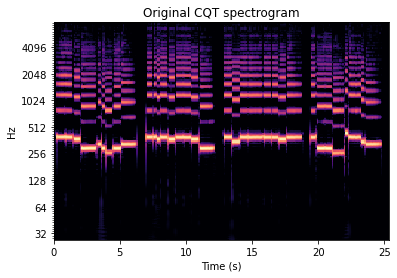

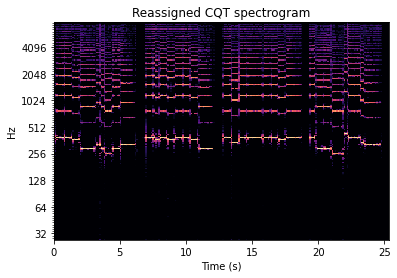

In [11]:
librosa.display.specshow(cqt1_db, y_axis='cqt_hz', x_axis='s', sr=Fs, hop_length=olap, bins_per_octave=bins_per_octave, fmin=fmin, fmax=fmax)
plt.title('Original CQT spectrogram')
plt.show()
librosa.display.specshow(recqt1_db, y_axis='cqt_hz', x_axis='s', sr=Fs, hop_length=olap, bins_per_octave=bins_per_octave, fmin=fmin, fmax=fmax)
plt.title('Reassigned CQT spectrogram')
plt.show()

### Spectral Ramp

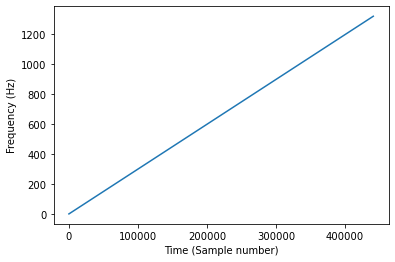

In [12]:
## spectral ramp
t = np.arange(0, 44100*10, 1)
f = t/(44100.*10.)*1320. # frequency linearly increasing with time
fs = 44100
func = np.sin(2*np.pi*f/fs*t)
x = func

plt.plot(f)
plt.xlabel('Time (Sample number)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [13]:
y = librosa.resample(x, fs, Fs)  # downsample to 16000 Hz
recqt2 = reassigned_cqt_spectrogram(y, Fs, n_bins, bins_per_octave, fmin, n_fft, olap, wlen, pad_mode)
recqt2_db = librosa.amplitude_to_db(recqt2, ref=np.max)
cqt2 = librosa.cqt(y, sr=Fs, hop_length=olap, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', pad_mode=pad_mode)
cqt2_db = librosa.amplitude_to_db(cqt2, ref=np.max)

C:\Users\maryp\Documents\envs\representations\Lib\site-packages\librosa\core\spectrum.py:1641: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn(


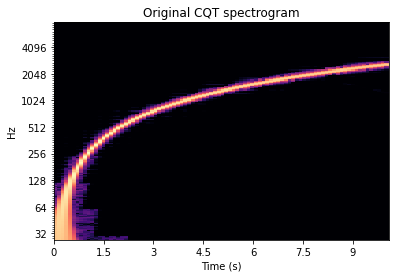

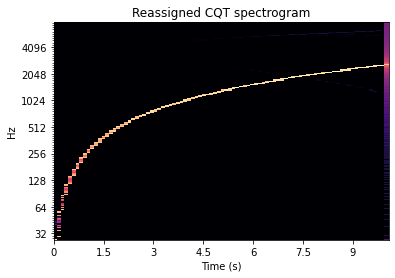

In [14]:
librosa.display.specshow(cqt2_db, y_axis='cqt_hz', x_axis='s', sr=Fs, hop_length=olap, bins_per_octave=bins_per_octave, fmin=fmin, fmax=fmax)
plt.title('Original CQT spectrogram')
plt.show()
librosa.display.specshow(recqt2_db, y_axis='cqt_hz', x_axis='s', sr=Fs, hop_length=olap, bins_per_octave=bins_per_octave, fmin=fmin, fmax=fmax)
plt.title('Reassigned CQT spectrogram')
plt.show()

### Sinewave

In [15]:
## sine wave
t = np.arange(0, 44100*10, 1)
f = 2500.
fs = 44100
func = np.sin(2*np.pi*f/fs*t)
x = func

In [16]:
y = librosa.resample(x, fs, Fs)  # downsample to 16000 Hz
recqt3 = reassigned_cqt_spectrogram(y, Fs, n_bins, bins_per_octave, fmin, n_fft, olap, wlen, pad_mode)
recqt3_db = librosa.amplitude_to_db(recqt3, ref=np.max)
cqt3 = librosa.cqt(y, sr=Fs, hop_length=olap, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, tuning=0.0, filter_scale=1, norm=1, sparsity=0.01, window='hann', pad_mode=pad_mode)
cqt3_db = librosa.amplitude_to_db(cqt3, ref=np.max)

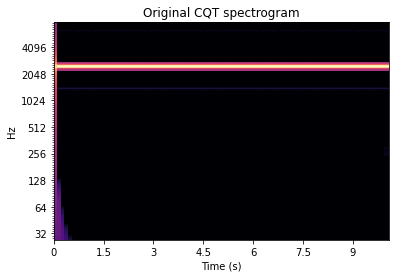

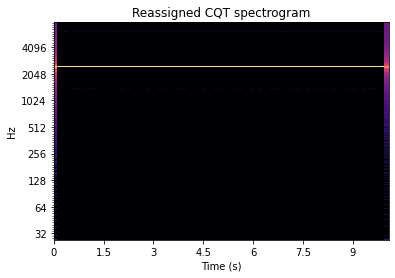

In [17]:
librosa.display.specshow(cqt3_db, y_axis='cqt_hz', x_axis='s', sr=Fs, hop_length=olap, bins_per_octave=bins_per_octave, fmin=fmin, fmax=fmax)
plt.title('Original CQT spectrogram')
plt.show()
librosa.display.specshow(recqt3_db, y_axis='cqt_hz', x_axis='s', sr=Fs, hop_length=olap, bins_per_octave=bins_per_octave, fmin=fmin, fmax=fmax)
plt.title('Reassigned CQT spectrogram')
plt.show()